In [101]:
import os
import glob
from Bio import SeqIO
from tqdm.auto import tqdm
import pylev
import matplotlib.pyplot as plt
import numpy as np

## Load all the unique sequences
These are the results for searching a database for homologues of:
- thioamide
- macroamidine
- azoline

#### Alternatively, Load the Interpro database sequences 

In [214]:
seqdump_dirs = glob.glob("../**/**seqdump.fa",recursive = True)

unique_sequence_ids = []
unique_sequences = []
num_sequences = 0
seqrecs_list = []
selected_seqdump_dirs = []
for seqdump_dir in seqdump_dirs:
    seqrecs = [seqrec for seqrec in SeqIO.parse(seqdump_dir,"fasta")]
    print(f"{seqdump_dir} has {len(seqrecs)} sequences")
    seqrecs_list.append(seqrecs)
    #Me removing certain files
    if ("Lasso" in seqdump_dir):
        selected_seqdump_dirs.append(seqdump_dir)

seqdump_dirs = selected_seqdump_dirs
#End of me removing certain files

for i in tqdm(range(len(seqdump_dirs)), desc='Loading all sequences'):
    seqrecs = seqrecs_list[i]
    seqdump_dir = seqdump_dirs[i]
    YcaO_type = seqdump_dir.split("/")[-3]
    YcaO_subclass = seqdump_dir.split("/")[-2]
    #print(YcaO_type,YcaO_subclass)
    for seqrec in seqrecs[:]:
        num_sequences += 1
        if seqrec.id not in unique_sequence_ids and num_sequences % 5 == 0:
            unique_sequence_ids.append(seqrec.id)
            #seqrec.id = f"{YcaO_type}_{YcaO_subclass}_{seqrec.id}"
            unique_sequences.append(seqrec)
            

# '''OVERWRITING UNIQUE SEQUENCES FOR SPEED OF PROCESSING'''
# unique_sequences = [seqrec for seqrec in SeqIO.parse("../raw_sequences/Azoline/Mccb17/HMMER_seqdump.fa","fasta")]     
print(f'From {num_sequences} searched sequences {len(unique_sequences)} are unique. Loaded in unique_sequences variable.')

interpro_seqrecs_dir = "../raw_sequences/interpro_all_YcaO_domain_sequences.txt"
interpro_seqrecs = [seqrec for seqrec in SeqIO.parse(interpro_seqrecs_dir,"fasta")]
filtered_interpro = []
for i in range(0,len(interpro_seqrecs)):
    if(i%1 == 0):
        filtered_interpro.append(interpro_seqrecs[i])

print(f"There are {len(filtered_interpro)} Interpro Sequences")

#Remove this line if you want to use my own sequences rather than the ones from interpro
unique_sequences = filtered_interpro

../raw_sequences/Amidine/Lasso_peptides/HMMER_seqdump.fa has 1665 sequences
../raw_sequences/Amidine/Jesko_but_unknown_outgroup_POTENTIALLY_IGNORE_DUE_TO_WEIRD_ALIGNMENT/outgroup_sequence_HMMER_seqdump.fa has 1779 sequences
../raw_sequences/Amidine/Jesko_but_unknown/HMMER_seqdump.fa has 14 sequences
../raw_sequences/Amidine/Bottromycin/HMMER_seqdump.fa has 273 sequences
../raw_sequences/Azoline/PZN_SEQUENCE_MAY_BE_WRONG/HMMER_seqdump.fa has 211 sequences
../raw_sequences/Azoline/Goadsporin/HMMER_seqdump.fa has 1750 sequences
../raw_sequences/Azoline/Thiopeptide_Lactazole/HMMER_seqdump.fa has 1595 sequences
../raw_sequences/Azoline/Thiostrepton/HMMER_seqdump.fa has 1205 sequences
../raw_sequences/Azoline/Sag/HMMER_seqdump.fa has 576 sequences
../raw_sequences/Azoline/Cyanobactins/PatD_HMMER_seqdump.fa has 1854 sequences
../raw_sequences/Azoline/Cyanobactins/TruD_HMMER_seqdump.fa has 1858 sequences
../raw_sequences/Azoline/Bottromycin/HMMER_seqdump.fa has 5 sequences
../raw_sequences/Azo

Loading all sequences: 100%|██████████| 1/1 [00:00<00:00, 230.74it/s]

From 1665 searched sequences 333 are unique. Loaded in unique_sequences variable.
There are 16431 Interpro Sequences


## Remove sequences that are too short to be considered YcaO or too long to be useful
# <center> A.K.A len > 700 or len < 300 </center>

In [215]:
filtered_sequences = []

for seq_rec in unique_sequences:
    if(len(seq_rec.seq)<1000 and len(seq_rec.seq)>350):
        filtered_sequences.append(seq_rec)

print(f'From {len(unique_sequences)} unique sequences. {len(filtered_sequences)} remain after processing')

From 16431 unique sequences. 15385 remain after processing


## Save unique sequences to file for intermediate bash processing

In [216]:
file_dir = './../processed_sequences/'
unique_seq_fp = os.path.join(file_dir, "unique_unaligned_sequences.txt")
SeqIO.write(filtered_sequences, unique_seq_fp, "fasta")

15385

## Remove Sequences with High Similarity using CD-HIT eg. 90% or 70% identity etc

In [217]:
identity_percentage = 0.95
filtered_by_identity_unique_seq_fp = os.path.join(file_dir, f"unique_filtered_{identity_percentage}_sequences.txt")

!./../external_scripts/cd-hit-v4.8.1-2019-0228/cd-hit -i $unique_seq_fp -o $filtered_by_identity_unique_seq_fp -c $identity_percentage -n 5 -d 0 -T 8 -M 16000

num_sequences = len([seq.id for seq in SeqIO.parse(filtered_by_identity_unique_seq_fp,"fasta")])
print(f"Started with {len(filtered_sequences)} sequences, after removing those with >{identity_percentage*100}% identity, we have {num_sequences} sequences!")
print(f"Saved as {filtered_by_identity_unique_seq_fp}")

Program: CD-HIT, V4.8.1 (+OpenMP), Dec 13 2022, 11:04:39
Command: ./../external_scripts/cd-hit-v4.8.1-2019-0228/cd-hit
         -i
         ./../processed_sequences/unique_unaligned_sequences.txt
         -o
         ./../processed_sequences/unique_filtered_0.95_sequences.txt
         -c 0.95 -n 5 -d 0 -T 8 -M 16000

Started: Wed Dec 21 22:37:59 2022
                            Output                              
----------------------------------------------------------------
total seq: 15385
longest and shortest : 996 and 351
Total letters: 8904880
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 11M
Buffer          : 8 X 10M = 87M
Table           : 2 X 65M = 131M
Miscellaneous   : 0M
Total           : 229M

Table limit with the given memory limit:
Max number of representatives: 4000000
Max number of word counting entries: 1971289464

# comparing sequences from          0  to       1538
.---------- new table with      972 representatives
# compa

# comparing sequences from      14400  to      15385
.................---------- new table with      605 representatives

    15385  finished       8180  clusters

Approximated maximum memory consumption: 237M
writing new database
writing clustering information
program completed !

Total CPU time 12.32
Started with 15385 sequences, after removing those with >95.0% identity, we have 8180 sequences!
Saved as ./../processed_sequences/unique_filtered_0.95_sequences.txt


## Compute aligned sequences using mafft

In [218]:
aligned_unique_seq_fp = os.path.join(file_dir, f"aligned_{identity_percentage}_identity_sequences.txt")

!mafft --auto --distout $filtered_by_identity_unique_seq_fp > $aligned_unique_seq_fp 

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..

There are 132 ambiguous characters.
 8101 / 8180
done.

Constructing a UPGMA tree (efffree=0) ... 
 8170 / 8180
done.

Progressive alignment 1/2... 
STEP  4901 / 8179 
Reallocating..done. *alloclen = 3120
STEP  6301 / 8179 
Reallocating..done. *alloclen = 4558
STEP  6801 / 8179 
Reallocating..done. *alloclen = 5807
STEP  7101 / 8179 
Reallocating..done. *alloclen = 9044

Reallocating..done. *alloclen = 10123
STEP  7301 / 8179 
Reallocating..done. *alloclen = 12676
STEP  7601 / 8179 
Reallocating..done. *alloclen = 16839
STEP  8001 / 8179  h
Reallocating..done. *alloclen = 19360
STEP  8101 / 8179 
done.

Making a distance matrix from msa.. 
 8100 / 8180
done.

Constructing a UPGMA tree (efffree=1) ... 
 8170 / 8180
done.

Progressive alignment 2/2... 
STEP  5901 / 8179 
Reallocating..done. *alloclen = 3030
STEP  6901 / 8179 
Reallocat

In [219]:
aligned_sequences = [seqrec for seqrec in SeqIO.parse(aligned_unique_seq_fp,"fasta")]
print(f"Aligned sequences have a length of {len(aligned_sequences[0].seq)} AAs")

Aligned sequences have a length of 16195 AAs


## Run Iq-Tree!

Best Model for 5sequences from each HMMER file was WAG+F+R5, (after filtering for long & short sequences it was Q.pfam+F+R4)

In [ ]:
asr = False
redo = True

redo_text = "-redo"
asr_text = "-asr"

print(f"CREATING TREE, Redoing? {redo}; Running ASR? {asr}")
!iqtree2 -s $aligned_unique_seq_fp {(redo_text if redo else "")} -T 47 -m Q.pfam+F+R4 -B 1000 {(asr_text if asr else "")}

CREATING TREE, Redoing? True; Running ASR? False
IQ-TREE multicore version 2.2.0 COVID-edition for Linux 64-bit built Jun  1 2022
Developed by Bui Quang Minh, James Barbetti, Nguyen Lam Tung,
Olga Chernomor, Heiko Schmidt, Dominik Schrempf, Michael Woodhams, Ly Trong Nhan.

Host:    dc4b1604e884 (AVX2, FMA3, 251 GB RAM)
Command: iqtree2 -s ./../processed_sequences/aligned_0.95_identity_sequences.txt -redo -T 47 -m Q.pfam+F+R4 -B 1000
Seed:    868463 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Wed Dec 21 18:56:06 2022
Kernel:  AVX+FMA - 47 threads (48 CPU cores detected)

Reading alignment file ./../processed_sequences/aligned_0.95_identity_sequences.txt ... Fasta format detected
Reading fasta file: done in 0.0569935 secs using 90.21% CPU
Alignment most likely contains protein sequences
Constructing alignment: done in 0.0540304 secs using 790.1% CPU
Alignment has 632 sequences with 3735 columns, 3387 distinct patterns
1982 parsimony-informative, 927 singleton site

                                                 Gap/Ambiguity  Composition  p-value
Analyzing sequences: done in 0.00092391 secs using 4163% CPU
   1  A0A014FBP3|IPR003776_159...573_|YcaO              80.40%    failed      0.00%
   2  A0A024F8Z1|IPR003776_69...452_|YcaO               87.90%    failed      0.00%
   3  A0A060DUB2|IPR003776_32...420_|YcaO               88.76%    failed      0.00%
   4  A0A063ZL38|IPR003776_238...583_|YcaO              84.39%    failed      0.00%
   5  A0A068T936|IPR003776_32...423_|YcaO               88.67%    failed      0.10%
   6  A0A075R4Z1|IPR003776_239...404_|YcaO              89.18%    failed      0.55%
   7  A0A077QLF5|IPR003776_11...432_|YcaO               84.28%    failed      0.96%
   8  A0A084D697|IPR003776_379...745_|YcaO              80.05%    failed      0.00%
   9  A0A085WV69|IPR003776_375...736_|YcaO              80.29%    failed      0.01%
  10  A0A090DMP9|IPR003776_12...385_|YcaO               89.69%    failed      0.24%
  11  A0A095VF


Create initial parsimony tree by phylogenetic likelihood library (PLL)... 2.415 seconds
Generating 1000 samples for ultrafast bootstrap (seed: 868463)...

NOTE: 1344 MB RAM (1 GB) is required!
Estimate model parameters (epsilon = 0.100)
1. Initial log-likelihood: -575024.382
2. Current log-likelihood: -493117.596
3. Current log-likelihood: -492504.060
4. Current log-likelihood: -492489.084
5. Current log-likelihood: -492486.662
6. Current log-likelihood: -492486.146
7. Current log-likelihood: -492486.005
Optimal log-likelihood: -492485.952
Site proportion and rates:  (0.040,0.139) (0.207,0.433) (0.394,0.839) (0.360,1.597)
Parameters optimization took 7 rounds (22.695 sec)
Wrote distance file to... 
Computing ML distances based on estimated model parameters...
Calculating distance matrix: done in 1.84008 secs using 4686% CPU
Computing ML distances took 1.842162 sec (of wall-clock time) 86.313510 sec (of CPU time)
Setting up auxiliary I and S matrices: done in 0.0188965 secs using 1155%

## Find redundant sequences to save compute

In [68]:
def pairwise_sequence_identity(seq_rec_1, seq_rec_2):
    seq_1 = str(seq_rec_1.seq)
    seq_2 = str(seq_rec_2.seq)
    
    num_matching = 0
    length = 0
    for i in range(len(seq_1)):
        if seq_1[i] == '-' and seq_2[i] == '-':
            continue
        if seq_1[i] == seq_2[i]:
            num_matching += 1
        length += 1
    return num_matching/length
seq_1, seq_2 = aligned_sequences[:2]
print(f'Sequence identity test between\nseq 1: {str(seq_1.seq)[:200]}...\nand\nseq 2: {str(seq_2.seq)[:200]}...')
identity_similarity = pairwise_sequence_identity(seq_1, seq_2)
print(f'Identity similarity = {identity_similarity}')

Sequence identity test between
seq 1: --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------...
and
seq 2: --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------...
Identity similarity = 0.9601769911504425


In [ ]:
redundant_sequences = set()
threshold = 0.7 # anything above 70% identity to the current seq will be filtered out

print(type(enumerate(aligned_sequences)))
# pbar = tqdm(enumerate(aligned_sequences), desc='Filtering sequences', total=len(aligned_sequences))
# for i, sequence in pbar:
#     if i in redundant_sequences:
#         continue
#     comparison_sequences = [(seq, j) for j, seq in enumerate(aligned_sequences) if j != i and j not in redundant_sequences]
#     for comp_seq, comp_seq_idx in comparison_sequences:
#         identity_similarity = pairwise_sequence_identity(sequence, comp_seq)
#         if identity_similarity > threshold: # if above threshold, then flag as redundant
#             redundant_sequences.add(comp_seq_idx)
#             pbar.set_description(f'Filtering sequences, found {len(redundant_sequences)} redundant')
# #             print(f'Found {i} has redundant sequence with {identity_similarity*100:.2f}% similarity.')
# #             print(f'We have {len(redundant_sequences)} redundant sequences.')

In [57]:
filtered_sequences = [seq for i, seq in enumerate(aligned_sequences) if i not in redundant_sequences]

100%|██████████| 45/45 [00:00<00:00, 132.32it/s]


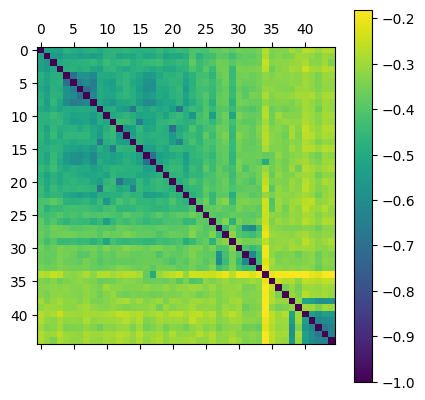

In [62]:
similarity_matrix = []

for i in tqdm(range(len(filtered_sequences))):
    row = []
    for j in range(len(filtered_sequences)):
        similarity = pairwise_sequence_identity(filtered_sequences[i], filtered_sequences[j])
        row.append(similarity)
    similarity_matrix.append(row)

m = np.array(similarity_matrix)
plt.matshow(-m)
plt.colorbar()

In [54]:
redundant_sequences

{1,
 3,
 4,
 6,
 7,
 8,
 9,
 10,
 12,
 13,
 14,
 15,
 17,
 18,
 21,
 22,
 23,
 24,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 39,
 41,
 42,
 44,
 48,
 49,
 50,
 51,
 52,
 55,
 56,
 57,
 58,
 62,
 63,
 64,
 65,
 67,
 70,
 72,
 81,
 85,
 91,
 92,
 96,
 97,
 98}

In [30]:
len(aligned_sequences)

999